In [2]:
import os
from itertools import combinations

import numpy as np
from scipy import linalg 
from scipy import stats 

import matplotlib.pyplot as plt

from langchain.agents import load_tools, initialize_agent
from langchain.agents import AgentType

from langchain.chat_models import ChatOpenAI

from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.algorithms import PC

from castle.common.priori_knowledge import PrioriKnowledge

In [3]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

In [ ]:
def check_if_dag(A):
    return np.trace(linalg.expm(A * A)) - A.shape[0] == 0

# Jane The Discoverer

A part of [CausalPython](https://causalpython.io) series on causality.

<a href="https://causalpython.io"><img src="img/CausalPython.io__flat.png" width=150 align="left"></a>
<br>

## Create the environment


To run this notebook use the environment called `causal-nlp-openai-langchain`.

To create it: `conda env create -f causal-nlp-openai-langchain.yml`

You'll need [Conda](https://docs.conda.io/en/latest/) to install it.

## Set the key

In [4]:
with open(r'../../__keys/openai.dat') as f:
    key = f.read()
    
os.environ['OPENAI_API_KEY'] = key

## Generate the data

In [9]:
all_vars = {
    'altitude': 0,
    'oxygen_density': 1,
    'temperature': 2,
    'risk_of_death': 3,
    'mehendretex': 4
}

In [10]:
SAMPLE_SIZE = 1000

altitude = stats.halfnorm.rvs(scale=2000, size=SAMPLE_SIZE)
temperature = 25 - altitude / 100 + stats.norm.rvs(
    loc=0,
    scale=2,
    size=SAMPLE_SIZE
)

mehendretex = stats.halfnorm.rvs(size=SAMPLE_SIZE)

oxygen_density = np.clip(
    1 - altitude / 8000 
    - temperature / 50 
    + stats.norm.rvs(size=SAMPLE_SIZE) / 20,
    0, 
    1)

risk_of_death = np.clip(
    altitude / 20000 
    + np.abs(temperature) / 100 
    - oxygen_density / 5 
    - mehendretex / 5
    + stats.norm.rvs(size=SAMPLE_SIZE) / 10,
    0,
    1
)

In [11]:
dataset = np.stack(
    [
        altitude,
        oxygen_density,
        temperature,
        risk_of_death,
        mehendretex
    ]
).T

In [12]:
true_dag = np.array(
    [
        [0, 1, 1, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]
    ]
)

## PC without LLM assistance

Is learned matrix a DAG: False


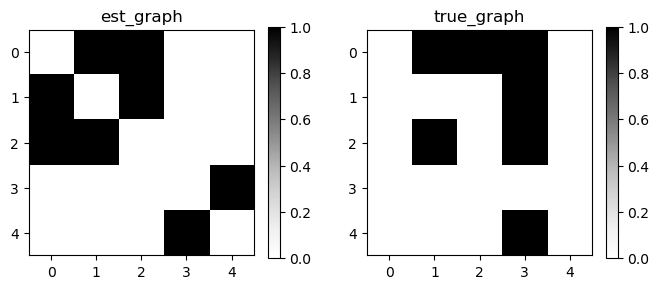

{'fdr': 0.0, 'tpr': 0.5714, 'fpr': 0.0, 'shd': 3, 'nnz': 4, 'precision': 0.5, 'recall': 0.5714, 'F1': 0.5333, 'gscore': 0.0}


In [13]:
# PC discovery without LLM assist
pc = PC(variant='stable')
pc.learn(dataset)

print(f'Is learned matrix a DAG: {check_if_dag(pc.causal_matrix)}')

# Vizualize
GraphDAG(
    est_dag=pc.causal_matrix, 
    true_dag=true_dag)

plt.show()

# Compute metrics
metrics = MetricsDAG(
    B_est=pc.causal_matrix, 
    B_true=true_dag)

print(metrics.metrics)

In [14]:
# Instantiate and encode priori knowledge
priori_knowledge = PrioriKnowledge(n_nodes=len(all_vars))

## Instantiate the GPT agent

In [5]:
llm = ChatOpenAI(
    temperature=0, # Temp == 0 => we want clear reasoning
    model='gpt-4')#'gpt-3.5-turbo') 

In [6]:
# Load tools
tools = load_tools(
    [
        "wikipedia"
    ], 
    llm=llm)

In [7]:
# Instantiate the agent
agent = initialize_agent(
    tools, 
    llm, 
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    verbose=False)

In [8]:
def get_llm_info(llm, agent, var_1, var_2):
    
    out = agent(f"Does {var_1} cause {var_2} or the other way around?\
    We assume the following definition of causation:\
    if we change A, B will also change.\
    The relationship does not have to be linear or monotonic.\
    We are interested in all types of causal relationships, including\
    partial and indirect relationships, given that our definition holds.\
    ")
    
    print(out)
    
    pred = llm.predict(f'We assume the following definition of causation:\
    if we change A, B will also change.\
    Based on the following information: {out["output"]},\
    print (0,1) if {var_1} causes {var_2},\
    print (1, 0) if {var_2} causes {var_1}, print (0,0)\
    if there is no causal relationship between {var_1} and {var_2}.\
    Finally, print (-1, -1) if you don\'t know. Importantly, don\'t try to\
    make up an answer if you don\'t know.')
    
    print(pred)
    
    return pred

## Add priori knowledge from the LLM

altitude oxygen_density
{'input': 'Does altitude cause oxygen_density or the other way around?    We assume the following definition of causation:    if we change A, B will also change.    The relationship does not have to be linear or monotonic.    We are interested in all types of causal relationships, including    partial and indirect relationships, given that our definition holds.    ', 'output': 'Altitude causes changes in oxygen density.'}
(0,1)
altitude temperature
{'input': 'Does altitude cause temperature or the other way around?    We assume the following definition of causation:    if we change A, B will also change.    The relationship does not have to be linear or monotonic.    We are interested in all types of causal relationships, including    partial and indirect relationships, given that our definition holds.    ', 'output': "Altitude and temperature interact in complex ways within the Earth's atmosphere, and it's not accurate to say that one causes the other. Changes 

C:\Users\aleks\anaconda3\envs\causal-nlp-openai-langchain\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\aleks\anaconda3\envs\causal-nlp-openai-langchain\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


{'input': 'Does oxygen_density cause risk_of_death or the other way around?    We assume the following definition of causation:    if we change A, B will also change.    The relationship does not have to be linear or monotonic.    We are interested in all types of causal relationships, including    partial and indirect relationships, given that our definition holds.    ', 'output': 'Changes in oxygen density can cause changes in the risk of death. Both low oxygen density (hypoxia) and high oxygen density (hyperoxia) can lead to health problems and increase the risk of death.'}
(0,1)
oxygen_density mehendretex
{'input': 'Does oxygen_density cause mehendretex or the other way around?    We assume the following definition of causation:    if we change A, B will also change.    The relationship does not have to be linear or monotonic.    We are interested in all types of causal relationships, including    partial and indirect relationships, given that our definition holds.    ', 'output': 

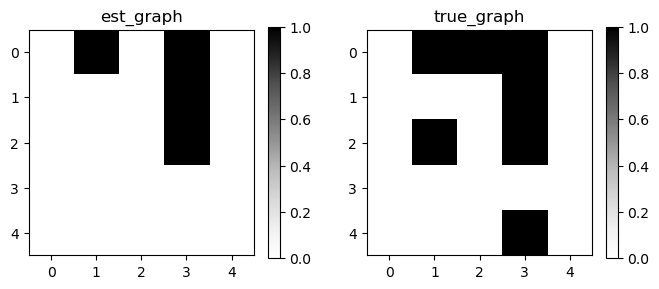


Running PC


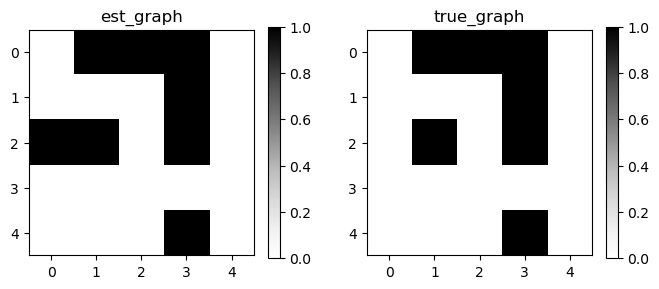

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 7, 'precision': 0.875, 'recall': 1.0, 'F1': 0.9333, 'gscore': 0.8571}


In [15]:
for var_1, var_2 in combinations(all_vars.keys(), r=2):
    print(var_1, var_2)
    out = get_llm_info(llm, agent, var_1, var_2)
    if out=='(0,1)':
        priori_knowledge.add_required_edges(
            [(all_vars[var_1], all_vars[var_2])]
        )
        
        priori_knowledge.add_forbidden_edges(
            [(all_vars[var_2], all_vars[var_1])]
        )

    elif out=='(1,0)':
        priori_knowledge.add_required_edges(
            [(all_vars[var_2], all_vars[var_1])]
        )
        priori_knowledge.add_forbidden_edges(
            [(all_vars[var_1], all_vars[var_2])]
        )

print('\nLLM knowledge vs true DAG')
priori_dag = np.clip(priori_knowledge.matrix, 0, 1)

print(f'\nChecking if priori graph is a DAG: {check_if_dag(priori_dag)}')

GraphDAG(
    est_dag=priori_dag, 
    true_dag=true_dag)

plt.show()

print('\nRunning PC')

# Instantiate the model with expert knowledge
pc_priori = PC(
    priori_knowledge=priori_knowledge,
    variant='stable'
)

# Learn
pc_priori.learn(dataset)

GraphDAG(
    est_dag=pc_priori.causal_matrix, 
    true_dag=true_dag)

plt.show()

# Compute metrics
metrics = MetricsDAG(
    B_est=pc_priori.causal_matrix, 
    B_true=true_dag)

print(metrics.metrics)